<a href="https://colab.research.google.com/github/armandordorica/MIE1516_A4_ConvNets/blob/master/CNN_Cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4
## Section 1. Convolutional Neural Network for Image Classification on Cifar-10 dataset

__Step 1:__

Download the Cifar-10 data https://www.cs.toronto.edu/~kriz/cifar.html and upload it to Colab. You can do this straight from here. See cell[3].

__Step 2:__

Train the CNN model to classify the Cifar-10 dataset and plot the train and test performance (all code is given below). The code is currently set to train for 2 epochs in cell [10] (so you can quickly verify the notebook is working), but you should train for 50 epochs when you save results for your final architecture.

__Objective:__

For this part of the assignment, your goal is to change the keras model (see https://keras.io/) to tune the layer settings, filter size, and filter shape to get better performance (85% test accuracy is possible, aim for at least 75% for full credit, above 85% will receive 1pt extra credit).

__Your final submission for this section should consist of this notebook with a modified keras model showing at least 75% test set accuracy after training for 50 epochs.__

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


In [2]:
## initialization
import os
import numpy as np
import _pickle as cPickle
import pandas as pd 
from numpy import argmax
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

import tensorflow.python.keras
from tensorflow.python.keras.models import Sequential 
from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras import backend as K
from keras.datasets import cifar10

Using TensorFlow backend.


## Upload and decompress the data

In [3]:
# You can upload the data straight to collab. --
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2020-03-22 03:34:41--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.2’

cifar-10-python.tar 100%[===================>] 162.60M  75.6MB/s    in 2.1s    

2020-03-22 03:34:43 (75.6 MB/s) - ‘cifar-10-python.tar.gz.2’ saved [170498071/170498071]



In [0]:
#now you have the compressed data uploaded to your Colab, unzip it using the following command line:
import tarfile
tar = tarfile.open("cifar-10-python.tar.gz")
tar.extractall()
tar.close()

In [0]:
PATH = "cifar-10-batches-py"

## Utility Functions

In [0]:
class Cifar(object):
    def __init__(self, input_path, dropout_index):
        self.input_path = input_path
        self.dropout_index = dropout_index
        self._get_data()
    
    @staticmethod
    def _unpickle(file):
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo, encoding='latin1')
        return dict
    
    @staticmethod
    def _getfiles(path):
        files = []
        for file in os.listdir(path):
            if "data_batch" in file:
                files.append(file)
        return files
 
    def _get_data(self):

        cifar_9_data = []
        cifar_9_labels = []
        cifar_1_data = []
        cifar_1_labels = []
        
        files = self._getfiles(self.input_path)

        for batch_file in files:
            batch = self._unpickle('{0}/{1}'.format(PATH, batch_file))
            labels = np.array(batch['labels'])
            keep_indexs = np.zeros(len(labels), dtype=bool)
            keep_indexs[labels!=self.dropout_index] = True
            cifar_9_data.append(batch['data'][keep_indexs])
            cifar_9_labels.append(labels[keep_indexs])
            drop_indexs = np.invert(keep_indexs)
            cifar_1_data.append(batch['data'][drop_indexs])
            cifar_1_labels.append(labels[drop_indexs])

        cifar_9_data = np.transpose(np.concatenate(cifar_9_data).reshape(-1,3,32,32), (0, 2, 3, 1))
        cifar_9_labels = np.concatenate(cifar_9_labels)
        cifar_1_data = np.transpose(np.concatenate(cifar_1_data).reshape(-1,3,32,32), (0, 2, 3, 1))
        cifar_1_labels = np.concatenate(cifar_1_labels)
        
        self.data = cifar_9_data.astype('float32')/255
        self.labels = tensorflow.keras.utils.to_categorical(cifar_9_labels, 10)
        
        self.trans_data = cifar_1_data.astype('float32')/255
        self.trans_labels = tensorflow.keras.utils.to_categorical(cifar_1_labels, 10)
        
    def next_data_batch(self, num):
        idx = np.arange(0, len(self.labels))
        np.random.shuffle(idx)
        idx = idx[:num]
        
        return self.data[idx], self.labels[idx]
        
    def next_trans_data_batch(self, num):
        idx = np.arange(0, len(self.trans_labels))
        np.random.shuffle(idx)
        idx = idx[:num]
        batch = self.data[idx]
        
        return self.trans_data[idx], self.trans_labels[idx]

## Load CIFAR data

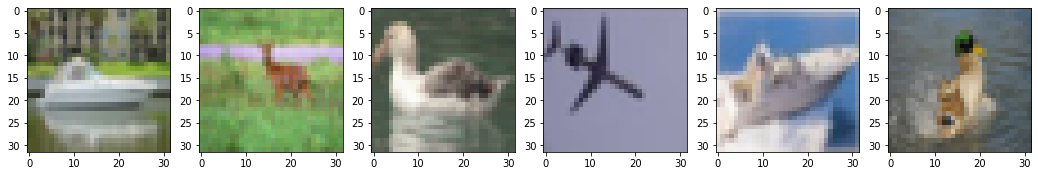

In [7]:
cifar = Cifar(PATH, 9)
data,labels = cifar.next_data_batch(6)
plt.figure(figsize=(18, 10))
reference = data
for i in range(reference.shape[0]):
    plt.subplot(int(reference.shape[0]/6)+1, 6, i+1)
    plt.imshow(reference[i])
    
plt.show()

In [8]:
data.shape

(6, 32, 32, 3)

## Define Keras deep net model and train

In [0]:
batch_size = 64
num_classes = 10
epochs = 20 # 50 is required for your final submission, but you can decrease for quick testing

In [16]:

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=cifar.data.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 64)       

In [17]:
# initiate RMSprop optimizer
opt = tensorflow.keras.optimizers.RMSprop(lr=0.001)
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
history = model.fit(cifar.data[:20000], cifar.labels[:20000],
                    batch_size=batch_size,
                    validation_data=(cifar.data[20001:30000], cifar.labels[20001:30000]),
                    epochs=epochs,
                    shuffle=True)

Train on 20000 samples, validate on 9999 samples
Epoch 1/20
20000/20000 [==============================] - 97s 5ms/sample - loss: 1.7970 - acc: 0.3349 - val_loss: 1.5099 - val_acc: 0.4507
Epoch 2/20
20000/20000 [==============================] - 97s 5ms/sample - loss: 1.4145 - acc: 0.4853 - val_loss: 1.3112 - val_acc: 0.5270
Epoch 3/20
20000/20000 [==============================] - 97s 5ms/sample - loss: 1.2387 - acc: 0.5578 - val_loss: 1.0754 - val_acc: 0.6201
Epoch 4/20
20000/20000 [==============================] - 97s 5ms/sample - loss: 1.1168 - acc: 0.6035 - val_loss: 1.4836 - val_acc: 0.5132
Epoch 5/20
20000/20000 [==============================] - 97s 5ms/sample - loss: 1.0220 - acc: 0.6406 - val_loss: 1.0986 - val_acc: 0.6310
Epoch 6/20
20000/20000 [==============================] - 97s 5ms/sample - loss: 0.9618 - acc: 0.6585 - val_loss: 0.9093 - val_acc: 0.6784
Epoch 7/20
20000/20000 [==============================] - 97s 5ms/sample - loss: 0.8969 - acc: 0.6841 - val_loss: 0.8

## Show train and test performance vs. epochs of gradient descent training

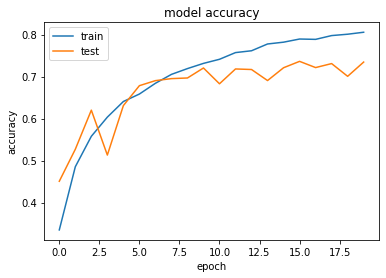

In [18]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Show confusion matrix of results

In [0]:
# Label Names(not gaven as metadata)
Label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
    ]

In [0]:
y_pred = np.argmax(model.predict(cifar.data[30000:]), axis=1)   
y_label = np.argmax(cifar.labels[30000:],axis=1)

In [0]:
def print_confusion_matrix(confusion_matrix, class_names, 
                           figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

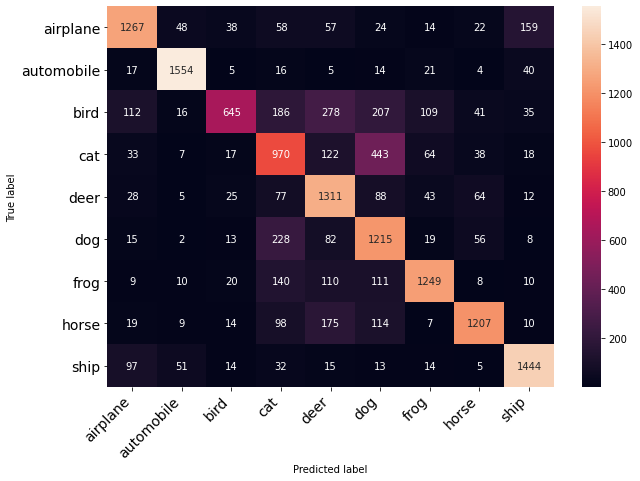

In [22]:
#  Cifar-9 Confusion Matrix
print_confusion_matrix(confusion_matrix(y_label, y_pred), 
                       Label_names[:9])

## Show predicted and actual labels for random images

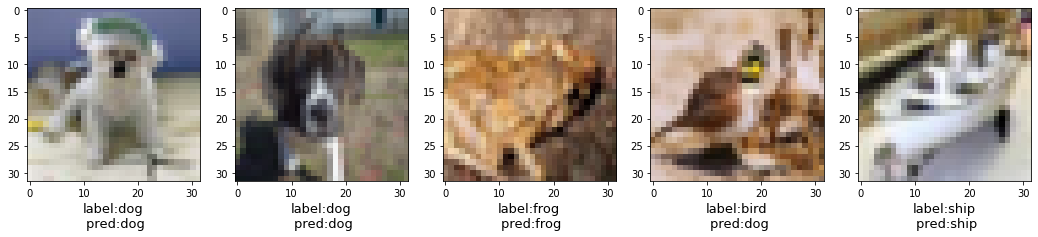

In [23]:
def random_examples(image, label, predict, Label_names, sample_size=5):
    plt.figure(figsize=(18, 10))
    reference = image[:sample_size]
    for i in range(reference.shape[0]):
        plt.subplot(int(reference.shape[0]/sample_size)+1, 
                    sample_size, i+1)
        plt.imshow(reference[i])
        plt.xlabel('label:{0}\n pred:{1}'.format(Label_names[label[i]],
                                                 Label_names[pred[i]]), 
                   fontsize=13)
    plt.show()
image,label = cifar.next_data_batch(5)
label = np.argmax(label, axis=1)
pred = np.argmax(model.predict(image), axis=1)
random_examples(image, label, pred, Label_names)